Credit [DNN tutorial](https://becominghuman.ai/build-your-own-neural-network-for-cifar-10-using-pytorch-9bdffb389b7a)

In [ ]:
import numpy as np
import cv2
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
FILE_PATH = '/content/drive/MyDrive/CV Project Workspace/Project_Code/Video_Audio_Combined/'
ACTORS = ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 
          'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 
          'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 
          'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
EMOTIONS = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}

In [ ]:
# Load preprocessed data for DNN
fetched_data = np.zeros([11307, 19728])
labels = np.zeros(11307)
data_index = 0

for actor in ACTORS:
  print(actor)
  file_path = FILE_PATH + actor + '/'
  for dirname, _, files in os.walk(file_path):
    for CURRENT_FILE in files:
      if CURRENT_FILE[21:] != 'face.csv':
        continue
      VIDEO_PATH = os.path.join(dirname, CURRENT_FILE)
      AUDIO_PATH = dirname+CURRENT_FILE[:21]+'audio.csv'

      video = []
      audio = []
      with open(VIDEO_PATH, 'r') as x:
        data = list(csv.reader(x, delimiter=","))
        video = np.array(data)
      with open(AUDIO_PATH, 'r') as x:
        data = list(csv.reader(x, delimiter=","))
        audio = np.array(data).flatten()
      for i in range(video.shape[0]):
        fetched_data[data_index] = np.concatenate([video[i], audio])
        labels[data_index] = np.array(int(CURRENT_FILE[7])-1)
        data_index += 1

Actor_01
Actor_02
Actor_03
Actor_04
Actor_05
Actor_06
Actor_07
Actor_08
Actor_09
Actor_10
Actor_11
Actor_12
Actor_13
Actor_14
Actor_15
Actor_16
Actor_17
Actor_18
Actor_19
Actor_20
Actor_21
Actor_22
Actor_23
Actor_24


In [ ]:
print(fetched_data[-1])

[  0.          18.02775638  35.35533906 ... -80.         -80.
 -80.        ]


In [ ]:
import random

example_nums = fetched_data.shape[0]
train_example_nums = int(0.8 * example_nums)
test_example_nums = int(0.1 * example_nums)
validation_example_nums = example_nums - train_example_nums - test_example_nums

random_ids = [i for i in range(example_nums)]
random.Random(4).shuffle(random_ids)

random_train_ids = random_ids[:train_example_nums]
random_test_ids = random_ids[train_example_nums:train_example_nums+test_example_nums]
random_validation_ids = random_ids[train_example_nums+test_example_nums:]

print(len(random_train_ids), len(random_test_ids), len(random_validation_ids))


X_train = torch.as_tensor(fetched_data[random_train_ids,:])
Y_train = torch.as_tensor(labels[random_train_ids]).type(torch.int64)

X_test = torch.as_tensor(fetched_data[random_test_ids,:])
Y_test = torch.as_tensor(labels[random_test_ids]).type(torch.int64)

X_vali = torch.as_tensor(fetched_data[random_validation_ids,:])
Y_vali = torch.as_tensor(labels[random_validation_ids]).type(torch.int64)


9045 1130 1132


In [ ]:
X_vali

tensor([[  0.0000,  16.1245,  32.3883,  ..., -80.0000, -80.0000, -80.0000],
        [  0.0000,  18.1108,  36.3456,  ..., -80.0000, -80.0000, -80.0000],
        [  0.0000,  17.0294,  33.2415,  ..., -80.0000, -80.0000, -80.0000],
        ...,
        [  0.0000,  18.1108,  35.6931,  ..., -80.0000, -80.0000, -80.0000],
        [  0.0000,  18.1108,  35.3553,  ..., -80.0000, -80.0000, -80.0000],
        [  0.0000,  15.8114,  31.9531,  ..., -79.9921, -79.9921, -79.9921]],
       dtype=torch.float64)

In [ ]:
Y_vali

tensor([0, 2, 1,  ..., 4, 4, 1])

In [ ]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.labels = Y
    self.features = X

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    feature = self.features[index]
    label = self.labels[index]
    return feature, label

In [ ]:
train_dataset = Dataset(X_train, Y_train)
test_dataset = Dataset(X_test, Y_test)
validation_dataset = Dataset(X_vali, Y_vali)

print(min(Y_train), max(Y_train))
print(Y_test)

tensor(0) tensor(7)
tensor([6, 6, 1,  ..., 4, 1, 2])


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class EmotionClassificationBase(nn.Module):
    def training_step(self, batch):
        features, labels = batch 
        out = self(features.type(torch.FloatTensor).to(device))                  # Generate predictions
        loss = F.cross_entropy(out, labels.to(device)) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        features, labels = batch
        out = self(features.type(torch.FloatTensor).to(device))                    # Generate predictions
        loss = F.cross_entropy(out, labels.to(device))   # Calculate loss
        acc = accuracy(out, labels.to(device))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum = 0.9)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
class DNN(EmotionClassificationBase):
  def __init__(self) -> None:
    super().__init__()
    self.fc1 = torch.nn.Linear(19728, 512)
    self.fc2 = torch.nn.Linear(512, 512)
    self.fc3 = torch.nn.Linear(512, 512)
    self.fc4 = torch.nn.Linear(512, 512)
    self.fc5 = torch.nn.Linear(512, 512)
    self.fc6 = torch.nn.Linear(512, 8)


  def forward(self, x: torch.Tensor) -> torch.Tensor:     
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    x = F.relu(x)
    x = self.fc5(x)
    x = F.relu(x)
    x = self.fc6(x)
    return x

In [ ]:
model = DNN()
model.to(device)
# train_dataset.labels = train_dataset.labels.to(device)
# train_dataset.faces = train_dataset.faces.to(device)
# test_dataset.labels = test_dataset.labels.to(device)
# test_dataset.faces = test_dataset.faces.to(device)
# validation_dataset.labels = validation_dataset.labels.to(device)
# validation_dataset.faces = validation_dataset.faces.to(device)

DNN(
  (fc1): Linear(in_features=19728, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=8, bias=True)
)

In [ ]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size*4)
val_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size*4)

In [ ]:
history = [evaluate(model, val_dataloader)]
history

[{'val_loss': 2.1882853507995605, 'val_acc': 0.08304398506879807}]

In [ ]:
history += fit(20, 0.0001 , model, train_dataloader, val_dataloader)

Epoch [0], val_loss: 1.8317, val_acc: 0.2997
Epoch [1], val_loss: 1.5952, val_acc: 0.3853
Epoch [2], val_loss: 1.5003, val_acc: 0.4309
Epoch [3], val_loss: 1.4203, val_acc: 0.4664
Epoch [4], val_loss: 1.3875, val_acc: 0.4923
Epoch [5], val_loss: 1.2581, val_acc: 0.5162
Epoch [6], val_loss: 1.4409, val_acc: 0.4588
Epoch [7], val_loss: 1.1180, val_acc: 0.5799
Epoch [8], val_loss: 1.1968, val_acc: 0.5918
Epoch [9], val_loss: 0.8949, val_acc: 0.6613
Epoch [10], val_loss: 1.7944, val_acc: 0.4238
Epoch [11], val_loss: 0.9942, val_acc: 0.6097
Epoch [12], val_loss: 0.6885, val_acc: 0.7534
Epoch [13], val_loss: 0.7324, val_acc: 0.7351
Epoch [14], val_loss: 0.7112, val_acc: 0.7518
Epoch [15], val_loss: 0.7047, val_acc: 0.7262
Epoch [16], val_loss: 0.7279, val_acc: 0.7158
Epoch [17], val_loss: 0.4622, val_acc: 0.8418
Epoch [18], val_loss: 0.4791, val_acc: 0.8434
Epoch [19], val_loss: 0.6161, val_acc: 0.7893


In [ ]:
history += fit(20, 0.00001 , model, train_dataloader, val_dataloader)

Epoch [0], val_loss: 0.3062, val_acc: 0.9018
Epoch [1], val_loss: 0.3110, val_acc: 0.9004
Epoch [2], val_loss: 0.3038, val_acc: 0.9054
Epoch [3], val_loss: 0.2775, val_acc: 0.9115
Epoch [4], val_loss: 0.2971, val_acc: 0.9117
Epoch [5], val_loss: 0.2557, val_acc: 0.9176
Epoch [6], val_loss: 0.2802, val_acc: 0.9009
Epoch [7], val_loss: 0.2446, val_acc: 0.9271
Epoch [8], val_loss: 0.2495, val_acc: 0.9152
Epoch [9], val_loss: 0.2466, val_acc: 0.9264
Epoch [10], val_loss: 0.2358, val_acc: 0.9219
Epoch [11], val_loss: 0.2404, val_acc: 0.9263
Epoch [12], val_loss: 0.2351, val_acc: 0.9282
Epoch [13], val_loss: 0.2135, val_acc: 0.9405
Epoch [14], val_loss: 0.2348, val_acc: 0.9192
Epoch [15], val_loss: 0.2031, val_acc: 0.9384
Epoch [16], val_loss: 0.2355, val_acc: 0.9343
Epoch [17], val_loss: 0.2009, val_acc: 0.9324
Epoch [18], val_loss: 0.2126, val_acc: 0.9261
Epoch [19], val_loss: 0.1840, val_acc: 0.9412


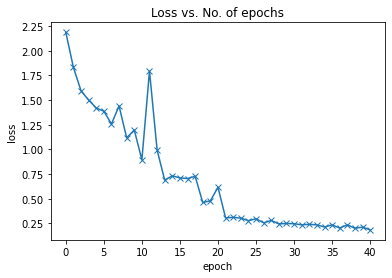

In [ ]:
plot_losses(history)

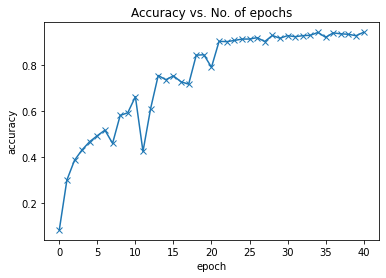

In [ ]:
plot_accuracies(history)

In [ ]:
evaluate(model, test_dataloader)

{'val_loss': 0.20402677357196808, 'val_acc': 0.9331269860267639}

In [ ]:
torch.save(model.state_dict(), 'emotion_classification-feedforward.pth')